# Image Colorization Final Project
Authors: Aret Tinoco, Keshav Gupta, Hal Halberstadt

Dataset: https://www.kaggle.com/datasets/darthgera/colorization

---

## Imports

In order to translate our data from RGB into LAB, an alternative color representation, we need to import the skimage package which is esentially an extension of sci-kit that has specific functions which make it simple and quick to modify whole images. An additional import we added is PIL, which allows us to easily resize images in order to control runtime and try various approaches without having to compute with full images.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image # for resizing images

from skimage import io, color

import tensorflow as tf
from tensorflow.keras import models, layers, Input, Model, callbacks, utils, callbacks, optimizers
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

from IPython.display import display, HTML

In [2]:
pd.set_option('display.max_columns', 200)
pd.options.display.width = 120
pd.options.display.max_colwidth = 50
display(HTML("<style>.container { width:100% !important; }</style>"))

---
## Initial Data Exploration

Here we set the directory where the data is, as well as the paths to the folders holding the different training and validation sets.The folder paths are defined here for easy access and as examples at the end of this notebook. The folder names are changed here so that they are more identifiable and so that they are easier to see. The files are too big to be held on github or onto Slack, but the main change that was done onto the [archive folder](https://www.kaggle.com/datasets/darthgera/colorization) from kaggle is changing the names and position of the folders so that it could be much easier understood and to be standardized.
We adapted the **read_subset** function from [homework 10](https://drive.google.com/file/d/1mb-NS3IqS5nQ563ps0kZj0zDpWUEp7ui/view) to take in the data. For initial exploration and the baseline model we decided to use a small subset of the data, about a fifteenth of the data.

 

In [3]:
data_dir = Path("C:/Users/Keshav Gupta/OneDrive/Desktop/archive") 
img_shape = (512, 512, 3)

folder_paths = ['color', 'bw', 'color_val', 'bw_val']

In [4]:
def read_folder(subset_name, data_dir):
    subset_dir = data_dir / subset_name
    pics = subset_dir.glob('*.jpg')
    num_pics = int(len(list(pics))/15)
    print(f"#imgs {num_pics}, folder '{subset_name}'")
    X = np.zeros((num_pics, img_shape[0], img_shape[1], img_shape[2]), dtype='float32')
    y = np.empty(num_pics, dtype='object')
    for i, pic in enumerate(subset_dir.glob('*.jpg')):
        if i < num_pics:
            pic_name = pic.name.split('-')[0]
            y[i] = pic_name
            img = load_img(pic)
            X[i] = img
        
    return (X / 255), y

In [5]:
X_train, X_train_label = read_folder(folder_paths[0], data_dir)
y_train, y_train_label = read_folder(folder_paths[1], data_dir)

#imgs 1333, folder 'color'
#imgs 1333, folder 'bw'


In [6]:
X_test, X_test_label = read_folder(folder_paths[3], data_dir) # BW imgs
y_test, y_test_label = read_folder(folder_paths[2], data_dir)

#imgs 166, folder 'bw_val'
#imgs 166, folder 'color_val'


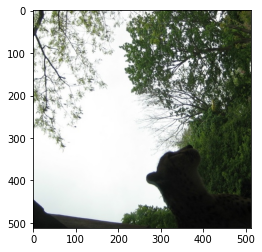

In [7]:
plt.imshow(X_train[0]);

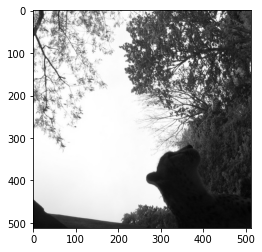

In [8]:
plt.imshow(y_train[0]);

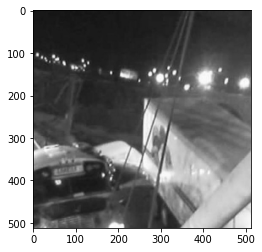

In [9]:
plt.imshow(X_test[0]);

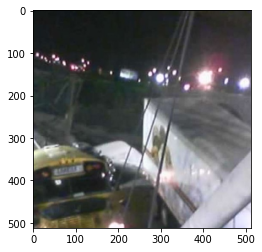

In [10]:
plt.imshow(y_test[0]);

---
## Baseline Model

Now that we have our data saved, we can build a baseline model to compare with future models. Our baseline model will consist of a few convolutional layers, and use RGB values for the input as well as predicting.

In [11]:
K.clear_session() 
act_fun='relu'

inputs=Input(img_shape)
filters=3

x = layers.SeparableConv2D(filters, 2, padding='same', activation=act_fun)(inputs)
x = layers.SeparableConv2D(filters, 2, padding='same', activation=act_fun)(x)
x = layers.SeparableConv2D(filters, 2, padding='same', activation=act_fun)(x)
x = layers.SeparableConv2D(filters, 2, padding='same', activation=act_fun)(x)

# Flatten and output Block
embedding_model = Model(inputs, x)

In [12]:
embedding_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
separable_conv2d (SeparableC (None, 512, 512, 3)       24        
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 512, 512, 3)       24        
_________________________________________________________________
separable_conv2d_2 (Separabl (None, 512, 512, 3)       24        
_________________________________________________________________
separable_conv2d_3 (Separabl (None, 512, 512, 3)       24        
Total params: 96
Trainable params: 96
Non-trainable params: 0
_________________________________________________________________


In [13]:
embedding_model.compile(optimizer='rmsprop', loss='mse',  metrics=tf.keras.losses.MeanSquaredError())
embedding_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5)

Epoch 1/5
42/42 [==============================] - 66s 2s/step - loss: 0.2400 - mean_squared_error: 0.2398 - val_loss: 0.2337 - val_mean_squared_error: 0.2314
Epoch 2/5
42/42 [==============================] - 67s 2s/step - loss: 0.2052 - mean_squared_error: 0.2051 - val_loss: 0.2025 - val_mean_squared_error: 0.2002
Epoch 3/5
42/42 [==============================] - 67s 2s/step - loss: 0.1760 - mean_squared_error: 0.1757 - val_loss: 0.1744 - val_mean_squared_error: 0.1721
Epoch 4/5
42/42 [==============================] - 68s 2s/step - loss: 0.1498 - mean_squared_error: 0.1495 - val_loss: 0.1490 - val_mean_squared_error: 0.1467
Epoch 5/5
42/42 [==============================] - 67s 2s/step - loss: 0.1260 - mean_squared_error: 0.1260 - val_loss: 0.1258 - val_mean_squared_error: 0.1234


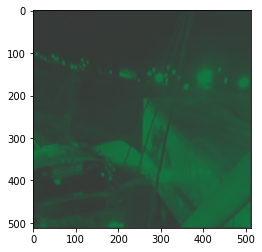

In [14]:
output = embedding_model.predict(X_test[:3])
plt.imshow(output[0]);

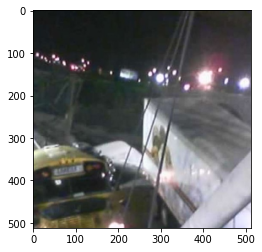

In [15]:
plt.imshow(y_test[0]);

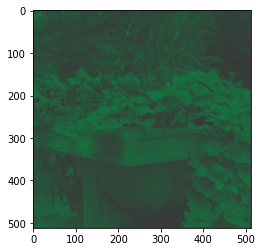

In [16]:
plt.imshow(output[1]);

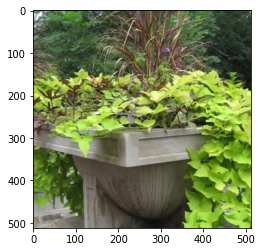

In [17]:
plt.imshow(y_test[1]);

### Baseline Analysis:
Our baseline model has a total of almost a hundred parameters, and after training for five epochs we displayed two of the images output from the model in order to visualize the results. From the output we see that the model is mainly applying one color to the image, making the image appear one color but still allowing distinct patterns in the image to be visable. From here our goal is to create a better model that is able to generate colors that look appropriate to the human eye.

---

## Data Generator
We need to provide the image shape as well as the size we want to reshape the image to. We are shrinking the images because computing 512x512 size color images became too computationally intensive, so reducing the width and height provided easier computation without loosing too much semantic information when viewed on its own.

In order to reduce running time when trying different models, we created sets of the data limiting it to a third of the total values, which was made by removing the last two thirds of data just so that we could see how it would train in comparison to different architectures before testing on the full dataset.

In [18]:
img_shape = (512, 512, 3)
shrink_shape = (128, 128, 3)

# Dataset locations
bw_dir_train = data_dir / folder_paths[1]
color_dir_val = data_dir / folder_paths[2]
bw_dir_val = data_dir / folder_paths[3]

Our Kernel cannot hold every image in memory, so we needed to get a generator in order to supply the model with the necessary images and do the correct translations to the images so that we could properly use them. The generator below was adapted from https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly by Afshine Amidi and Shervine Amidi, which we altered in order to output the black and white images, and a color verison using LAB color scheme. We also have modified the generator to take the images from different file locations in archive since the images that are colored and black and white have the same .jpg file name and need to be stored in a seperate folder. The batch size has also been reduced to one for stochastic batches, which when testing seemed to not alter performance or runtime until the batch size grew to big for the kernel to hold. What did need to be added here was resizing images in order to cut down runtime. We are using skimage's library for translation from RGB to LAB color schemes for repeatability and also since the translation can be applied to the full image and does not add much to training time. The other smaller modifications was removing some variables that were unnecessary for this generator. 

In [19]:
class DataGenerator(utils.Sequence): 
    '''
    adapted from https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
    
    Generates a color (rbg/lab) and black & white image for training data
    '''
    def __init__(self, ids, batch_size=1, 
                 dim=shrink_shape, n_channels=1, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = ids
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)
        
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        # Initialization
        X = np.empty((self.batch_size, *self.dim))
        y = np.empty((self.batch_size, *self.dim))

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # B/W image
            img = load_img(ID)
            img = img.resize(shrink_shape[:2])
            img = np.array(img, dtype=np.float32)/255
            img = img ** 1/2.2 #rgb to srgb
            img = color.rgb2lab(img)
            
            X[i] = img
            
            # get location of color image
            color_ID = str(ID)
            color_ID = color_ID.replace("bw", "color")
            
            # target image
            img_y = load_img(color_ID)
            img_y = img_y.resize(shrink_shape[:2])
            img_y = np.array(img_y, dtype=np.float32)/255
            img_y = img_y ** 1/2.2 #rgb to srgb
            img_y = color.rgb2lab(img_y)

            y[i] = img_y

        return X, y

In [20]:
partition_bw = list(bw_dir_train.glob('*.jpg'))
partition_bw_val = list(bw_dir_val.glob('*.jpg'))
partition_color = list(color_dir_val.glob('*.jpg'))

# Generators
training_generator = DataGenerator(partition_bw)
validation_generator = DataGenerator(partition_bw_val)

---

## Model

This style of model has been used in a lot of image colorization papers, calling it a 'U-net'. The basic structure is to have convolutional layers that shrink the image down and size it back so the layers end up looking like a 'U'. As the image starts getting bigger, or getting transposed back to it's original shape you add back outputs from the the same "height" of the U. This is useful because this architecture shrinks the image allowing for faster training as the image shrinks but to add back what it loses as the image comes back to full size. The main deviations from that basic model is the choice to use stride instead of pooling layers, and then adding back in one channel at the end from the beginning as the light channel of LAB. 

We played with the number of filters and their size with the larger the filter the "foggier" the image ended up being, so we ended up using size two with thirty two filters since they grow exponentially as the model gets to the lower levels. Adding dropout did help no matter how high, with around a 0.01-0.02 improvement, with generally the best improvements hovering around 0.1-0.3. We tried a lot of activations, relu, elu and selu with almost exactly the same results for each, but eventually we found using LeakyReLU added another percentage point or two, seemingly regardless of the alpha value, so we kept that at it's default value.

In [21]:
K.clear_session() 
_padding = 'same'
_stride = 2
k_size = 2
_filters = 32
dropout_rate = 0.3
act_fun = layers.LeakyReLU(alpha=0.3)

We need to define two seperate models here that have the same architecture just so that it is ensured the weights will be different. The weights need to be different since each is guessing a different channel, A and B, then the final model adds the light back in and concatenates the outputs into the final image in LAB color scheme.

Here is the A channel model for the "U" shaped model architecture with its own weights. 

In [22]:
'''U-shape model'''
inputs = Input((shrink_shape), name="img_input")

x = layers.SeparableConv2D(1, k_size, activation=act_fun, padding=_padding)(inputs)
residual = x

# topmost start
x = layers.SeparableConv2D(_filters, k_size, strides=_stride, activation=act_fun, padding=_padding)(x)
x = layers.SeparableConv2D(_filters, k_size, activation=act_fun, padding=_padding)(x)
x = layers.SpatialDropout2D(dropout_rate)(x)
x = layers.Conv2D(_filters, k_size, padding=_padding)(x)
x = layers.BatchNormalization(axis=3)(x)
x = layers.LeakyReLU()(x)
residual1 = x
x = layers.SeparableConv2D(_filters, k_size, activation=act_fun, padding=_padding)(x)

# 2nd layer start
x = layers.SeparableConv2D(_filters*2, k_size, strides=_stride, activation=act_fun, padding=_padding)(x)
x = layers.SeparableConv2D(_filters*2, k_size, activation=act_fun, padding=_padding)(x)
x = layers.SpatialDropout2D(dropout_rate)(x)
x = layers.SeparableConv2D(_filters*2, k_size, padding=_padding)(x)
x = layers.BatchNormalization(axis=3)(x)
x = layers.LeakyReLU()(x)
residual2 = x
x = layers.SeparableConv2D(_filters*2, k_size, activation=act_fun, padding=_padding)(x)

# 3rd layer
x = layers.SeparableConv2D(_filters*4, k_size, strides=_stride, activation=act_fun, padding=_padding)(x)
residual3 = x
x = layers.SeparableConv2D(_filters*4, k_size, activation=act_fun, padding=_padding)(x)
x = layers.SpatialDropout2D(dropout_rate)(x)
x = layers.SeparableConv2D(_filters*4, k_size, padding=_padding)(x)
x = layers.BatchNormalization(axis=3)(x)
x = layers.LeakyReLU()(x)
x = layers.SeparableConv2D(_filters*4, k_size, activation=act_fun, padding=_padding)(x)
x = layers.SeparableConv2D(_filters*4, k_size, padding=_padding)(x)
x = layers.BatchNormalization(axis=3)(x)
x = layers.LeakyReLU()(x)
x = layers.Add()([residual3, x])
x = layers.SeparableConv2D(_filters*4, k_size, activation=act_fun, padding=_padding)(x)
x = layers.Conv2DTranspose(_filters*4, k_size, strides=_stride, activation=act_fun, padding=_padding)(x)

# 2nd layer end
x = layers.SeparableConv2D(_filters*2, k_size, activation=act_fun, padding=_padding)(x)
x = layers.SpatialDropout2D(dropout_rate)(x)
x = layers.SeparableConv2D(_filters*2, k_size, padding=_padding)(x)
x = layers.BatchNormalization(axis=3)(x)
x = layers.LeakyReLU()(x)
x = layers.SeparableConv2D(_filters*2, k_size, activation=act_fun, padding=_padding)(x)
x = layers.Add()([residual2, x])
x = layers.Conv2DTranspose(_filters*2, k_size, strides=_stride, activation=act_fun, padding=_padding)(x)

# topmost end
x = layers.SeparableConv2D(_filters, k_size, activation=act_fun, padding=_padding)(x)
x = layers.BatchNormalization(axis=3)(x)
x = layers.LeakyReLU()(x)
x = layers.SeparableConv2D(_filters, k_size, activation=act_fun, padding=_padding)(x)
x = layers.Add()([residual1, x])
x = layers.Conv2DTranspose(_filters, k_size, strides=_stride, activation=act_fun, padding=_padding)(x)

x = layers.Add()([residual, x])
x = layers.SeparableConv2D(1, k_size, activation=act_fun, padding=_padding)(x)

a_model = Model(inputs, x)

The B channel model, which is the same as the a channel, just with seperate weights.

In [23]:
'''U-shape model'''
inputs = Input((shrink_shape), name="img_input")

x = layers.SeparableConv2D(1, k_size, activation=act_fun, padding=_padding)(inputs)
residual = x

# topmost start
x = layers.SeparableConv2D(_filters, k_size, strides=_stride, activation=act_fun, padding=_padding)(x)
x = layers.SeparableConv2D(_filters, k_size, activation=act_fun, padding=_padding)(x)
x = layers.SpatialDropout2D(dropout_rate)(x)
x = layers.Conv2D(_filters, k_size, padding=_padding)(x)
x = layers.BatchNormalization(axis=3)(x)
x = layers.LeakyReLU()(x)
residual1 = x
x = layers.SeparableConv2D(_filters, k_size, activation=act_fun, padding=_padding)(x)

# 2nd layer start
x = layers.SeparableConv2D(_filters*2, k_size, strides=_stride, activation=act_fun, padding=_padding)(x)
x = layers.SeparableConv2D(_filters*2, k_size, activation=act_fun, padding=_padding)(x)
x = layers.SpatialDropout2D(dropout_rate)(x)
x = layers.SeparableConv2D(_filters*2, k_size, padding=_padding)(x)
x = layers.BatchNormalization(axis=3)(x)
x = layers.LeakyReLU()(x)
residual2 = x
x = layers.SeparableConv2D(_filters*2, k_size, activation=act_fun, padding=_padding)(x)

# 3rd layer
x = layers.SeparableConv2D(_filters*4, k_size, strides=_stride, activation=act_fun, padding=_padding)(x)
residual3 = x
x = layers.SeparableConv2D(_filters*4, k_size, activation=act_fun, padding=_padding)(x)
x = layers.SpatialDropout2D(dropout_rate)(x)
x = layers.SeparableConv2D(_filters*4, k_size, padding=_padding)(x)
x = layers.BatchNormalization(axis=3)(x)
x = layers.LeakyReLU()(x)
x = layers.SeparableConv2D(_filters*4, k_size, activation=act_fun, padding=_padding)(x)
x = layers.SeparableConv2D(_filters*4, k_size, padding=_padding)(x)
x = layers.BatchNormalization(axis=3)(x)
x = layers.LeakyReLU()(x)
x = layers.Add()([residual3, x])
x = layers.SeparableConv2D(_filters*4, k_size, activation=act_fun, padding=_padding)(x)
x = layers.Conv2DTranspose(_filters*4, k_size, strides=_stride, activation=act_fun, padding=_padding)(x)

# 2nd layer end
x = layers.SeparableConv2D(_filters*2, k_size, activation=act_fun, padding=_padding)(x)
x = layers.SpatialDropout2D(dropout_rate)(x)
x = layers.SeparableConv2D(_filters*2, k_size, padding=_padding)(x)
x = layers.BatchNormalization(axis=3)(x)
x = layers.LeakyReLU()(x)
x = layers.SeparableConv2D(_filters*2, k_size, activation=act_fun, padding=_padding)(x)
x = layers.Add()([residual2, x])
x = layers.Conv2DTranspose(_filters*2, k_size, strides=_stride, activation=act_fun, padding=_padding)(x)

# topmost end
x = layers.SeparableConv2D(_filters, k_size, activation=act_fun, padding=_padding)(x)
x = layers.BatchNormalization(axis=3)(x)
x = layers.LeakyReLU()(x)
x = layers.SeparableConv2D(_filters, k_size, activation=act_fun, padding=_padding)(x)
x = layers.Add()([residual1, x])
x = layers.Conv2DTranspose(_filters, k_size, strides=_stride, activation=act_fun, padding=_padding)(x)

x = layers.Add()([residual, x])
x = layers.SeparableConv2D(1, k_size, activation=act_fun, padding=_padding)(x)

b_model = Model(inputs, x)

In [24]:
a_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img_input (InputLayer)          [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
separable_conv2d (SeparableConv (None, 128, 128, 1)  16          img_input[0][0]                  
__________________________________________________________________________________________________
separable_conv2d_1 (SeparableCo (None, 64, 64, 32)   68          separable_conv2d[0][0]           
__________________________________________________________________________________________________
separable_conv2d_2 (SeparableCo (None, 64, 64, 32)   1184        separable_conv2d_1[0][0]         
_______________________________________________________________________________________

This model concatenates the A and B channels with the light input.

In [25]:
inputs = Input((shrink_shape), name="img_input")

light = layers.Conv2D(1, k_size, padding=_padding)(inputs)
b_channel = b_model(inputs)
a_channel = a_model(inputs)

x = layers.Concatenate(axis=3)([light, a_channel, b_channel])

model = Model(inputs, x)

In [26]:
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img_input (InputLayer)          [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 1)  13          img_input[0][0]                  
__________________________________________________________________________________________________
functional_1 (Functional)       (None, 128, 128, 1)  225077      img_input[0][0]                  
__________________________________________________________________________________________________
functional_3 (Functional)       (None, 128, 128, 1)  225077      img_input[0][0]                  
_______________________________________________________________________________________

---

## Training

We define callbacks for the model with EarlyStopping and ReduceLROnPlateau, with the former primarily used to stop training once the model reaches the optimal loss and the latter to reduce the learning rate since it has provided a little extra accuracy during training. Validation loss seems to be the best value to monitor because we want the colors generated by the model to be more believable than accurate. The optimizer used is RMSProp, after trying Adagrad and variations of Adam, altering the learning rate, and momentum. We ended up on RMSProp since it tended to get the same or slightly better results than the Adam functions we used. With picture similarity, the loss is best described with loss functions such as 'mean absolute error' and 'mean squared error' which compare the direct values of each channel. 

In [27]:
my_monitor = "val_loss"
my_callbacks = [
    callbacks.EarlyStopping(monitor=my_monitor, min_delta=.01, patience=4),
    callbacks.ReduceLROnPlateau(monitor=my_monitor, factor=0.02, min_delta=.01, patience=2, verbose=1)
]

my_opt = optimizers.RMSprop(learning_rate=0.002, momentum=0.3)

In [28]:
model.compile(optimizer=my_opt, loss='mean_absolute_error',  metrics=['accuracy'])

history = model.fit(training_generator, callbacks=my_callbacks, validation_data=validation_generator, epochs=100)

Epoch 1/100
20000/20000 [==============================] - 824s 41ms/step - loss: 3.4836 - accuracy: 0.8757 - val_loss: 3.8992 - val_accuracy: 0.8562
Epoch 2/100
20000/20000 [==============================] - 810s 40ms/step - loss: 3.3801 - accuracy: 0.8790 - val_loss: 3.8828 - val_accuracy: 0.8552
Epoch 3/100
20000/20000 [==============================] - 811s 41ms/step - loss: 3.3694 - accuracy: 0.8798 - val_loss: 3.8963 - val_accuracy: 0.8572
Epoch 4/100
19999/20000 [============================>.] - ETA: 0s - loss: 3.3637 - accuracy: 0.8801
Epoch 00004: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
20000/20000 [==============================] - 810s 40ms/step - loss: 3.3636 - accuracy: 0.8801 - val_loss: 3.8911 - val_accuracy: 0.8525
Epoch 5/100
20000/20000 [==============================] - 804s 40ms/step - loss: 3.3210 - accuracy: 0.8810 - val_loss: 3.8606 - val_accuracy: 0.8606
Epoch 6/100
20000/20000 [==============================] - 799s 40ms/step - loss

---

## Example Results

After training our model, we decided to test it by using the model on black and white images from our test set which does not include color versions of the images. We displayed the generated color images in order to visualize the results of the model.

We import the test images from a seperate folder and resize them as well as convert them to LAB in order to prepare the images for the model.

In [29]:
n_img = 5
image_number = 1

In [45]:
dir_test = Path("C:/Users/Keshav Gupta/OneDrive/Desktop/archive/test_bw") 
partition_test = list(dir_test.glob('*.jpg'))

imgs_x = np.zeros((n_img, shrink_shape[0], shrink_shape[1], shrink_shape[2]), dtype='float32')
imgs_p = np.zeros((n_img, shrink_shape[0], shrink_shape[1], shrink_shape[2]), dtype='float32')

i = 0
for location in partition_test[:n_img]:
    img = load_img(location)
    img = img.resize(shrink_shape[:2])
    img = np.array(img, dtype=np.float32)
    img = img/255
    imgs_x[i] = img
    img = img ** 1/2.2 #rgb to srgb
    imgs_p[i] = color.rgb2lab(img)
    i += 1
    
output = model.predict((imgs_p))
output_pic = color.lab2rgb(output[image_number])

The first input and predicted image: 

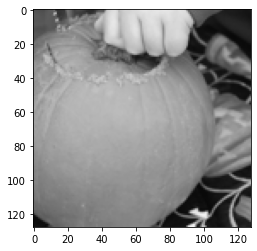

In [46]:
plt.imshow(imgs_x[image_number]);

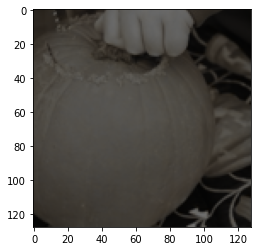

In [47]:
plt.imshow(output_pic);

The second input and predicted image: 

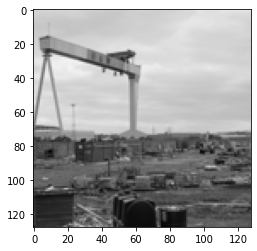

In [48]:
plt.imshow(imgs_x[image_number+1]);

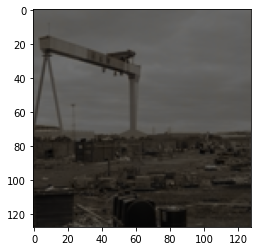

In [49]:
output_pic = color.lab2rgb(output[image_number+1])
plt.imshow(output_pic);

The third input and predicted image: 

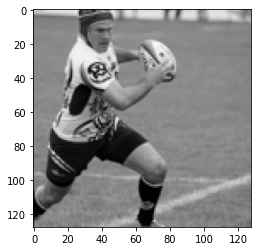

In [50]:
plt.imshow(imgs_x[image_number+2]);

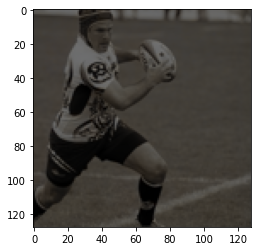

In [51]:
output_pic = color.lab2rgb(output[image_number+2])
plt.imshow(output_pic);

---

## Conclusions

The types of models we tried were a __[multi-headed model](https://github.com/halHalberstadt/Image-Colorization-CST438-Final-Project/blob/dev-hal-hsl1/Image-Colorization-Final.ipynb)__, a __[multi-head siamese model](https://github.com/halHalberstadt/Image-Colorization-CST438-Final-Project/blob/dev-hal/Image-Colorization-Final-rgb.ipynb)__, a [foward-feeding model](https://github.com/halHalberstadt/Image-Colorization-CST438-Final-Project/blob/dev-aret-rbg/Image-Colorization-Final(1).ipynb) and a modified U-net model (current). 

We also tried a couple different color representations, initially by trying to predict RBG channels directly from greyscale __[(here is the inital attempt)](https://github.com/halHalberstadt/Image-Colorization-CST438-Final-Project/blob/dev-hal-2/Image-Colorization-Final.ipynb)__. We then tried to change the colors to HLS format using colorsys, so that we did not need to predict the light level in the images. When we initally tried to do so, generating the batches took too long, around an hour for a single epoch. In order to address that, we tried using a python script in order to save the HLS data so that it wouldn't take the extra time in each epoch. Here is the python script to convert the images:

```python
###########################
# img RGB to HSL converter
###########################

from pathlib import Path
from PIL import Image
import numpy as np
import colorsys
import csv
data_dir = Path("D:/archive/color_val")
#data_dir = Path("D:/archive/color")
img_shape = (512, 512, 3)

data = list(data_dir.glob('*.jpg'))
num_pics = len(list(data))
for img in data:
    # for every image in folder
    csv_img = Image.open(img)
    arr = np.asarray(csv_img)
    lst = []
    for row in arr:
        tmp = []
        for col in row:
            #print(col) # pixel
            pixel = colorsys.rgb_to_hls(col[0], col[1], col[2])
            pixel = np.asarray(pixel)
            #print(pixel)
            tmp.append(bytes(pixel))
        lst.append(tmp)
    lst = np.asarray(lst)
    lst.tofile( str(img).replace(".jpg", "")+".npy")
    print(f"{num_pics} left")
    num_pics -= 1
    #f.close()

#############
# END
#############
```
The script took a substantial amount of time to run, and at the end of running, the resulting files took up at minimum 30GB of space on top of the 6GB of the black and white and color images. Upon trying to get the files back into a usable form for Keras/Tensorflow the conversion reduced the time to about thirty minutes per epoch with a few thousand parameters. We then started to use LAB color scheme, where L represents light, A and B represent red to green and blue to yellow respectively. This color scheme provided the same benefit of HLS, having only two channels to predict while increasing the time per epoch only slighlty.

The first observation we made when creating our baseline model is that the smaller models tend to tint the whole image in a way that makes the contents of the image still visible. The assumption is that the model found the most common colors for each image and applied that color tint to the predicted images. After our baseline, we also decided to reduce the size of the images in order to allow larger models to train faster. Only with the dense U-shaped LAB nets we started to get other colors mixed in some results as apposed to just adding a single-color tint to the image. 

In the end, our final U-shaped net had around 450 thousand parameters and training took around two hours. After training, we chose three random images from the test set to test our model with. The resulting images from the model showed slight colorization, mainly with tones of brown, however, the images appear dark and lack variation of color. We found that our second test image visually looked the best, which we theorize could be due to the model understanding some semantic relationships such as a cloudy sky typically appearing more light in color. In conclusion, we weren't able to meet our goal of accurately colorizing the images, but we learned a lot about different color representations, processing and storing images, and CNN architectures. For example, we researched and attempted using different color representations including RGB, HSL, HSV, and LAB. In trying different color representation, we wrote various scripts and generators to process and store the images in various formats such as csv and binary files. Finally, we built several models following varying architectures such as the multi-headed siamese model or the U-shaped model, which we ended up sticking with.   
